In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import date
from datetime import datetime
from bs4 import BeautifulSoup
import requests
import re

<h1>Part 2 - S&P and portfolio segment analysis with recommendations</h1>

<p>Using S&P 500 as the benchmark for basic stock portfolio diversification, this script will perform a segment analysis (K means clustering) on the companies in the index based on selected features.</p>

<p>Based on the model, the personal portfolio stats will be used to match the clusters in the S&P 500 index and get stock recommendations.</p>

<h2>Item 1 - S&P segment analysis</h2>
<h3>Choosing the features from the selected portfolio</h3>

In [29]:
source_date = '2022-12-31'
sp_yahoo_df = pd.read_csv(f'data/s&p_{source_date}.csv', index_col = 1)
sp_yahoo_df.columns

Index(['Unnamed: 0', 'Market Cap (B)', 'Enterprise Value (B)', 'Trailing P/E',
       'Forward P/E', 'PEG Ratio (5 yr expected)', 'Price/Sales (ttm)',
       'Price/Book (mrq)', 'Enterprise Value/Revenue',
       'Enterprise Value/EBITDA', 'Beta (5Y Monthly)', '52 Week Change (%)',
       'S&P500 52-Week Change (%)', '52 Week High', '52 Week Low',
       '50-Day Moving Average', '200-Day Moving Average',
       'Avg Vol 3 month (M)', 'Avg Vol 10 day (M)', 'Shares Outstanding',
       'Implied Shares Outstanding', 'Float', '% Held by Insiders',
       '% Held by Institutions', 'Shares Short (M)', 'Short Ratio (M)',
       'Short % of Float', 'Short % of Shares Outstanding', 'Shares Short',
       'Forward Annual Dividend Rate', 'Forward Annual Dividend Yield (%)',
       'Trailing Annual Dividend Rate', 'Trailing Annual Dividend Yield (%)',
       '5 Year Average Dividend Yield', 'Payout Ratio (%)',
       'Last Split Factor (x:1)', 'Profit Margin (%)',
       'Operating Margin (ttm) (%

In [30]:
#Choose the features for analysis
features = ['Market Cap (B)', 'Revenue (ttm) (B)', 'Profit Margin (%)','Quarterly Earnings Growth (yoy) (%)', '52 Week Change (%)']

X = sp_yahoo_df.loc[:,features]

<h3>Quick visualisation of the relationships</h3>

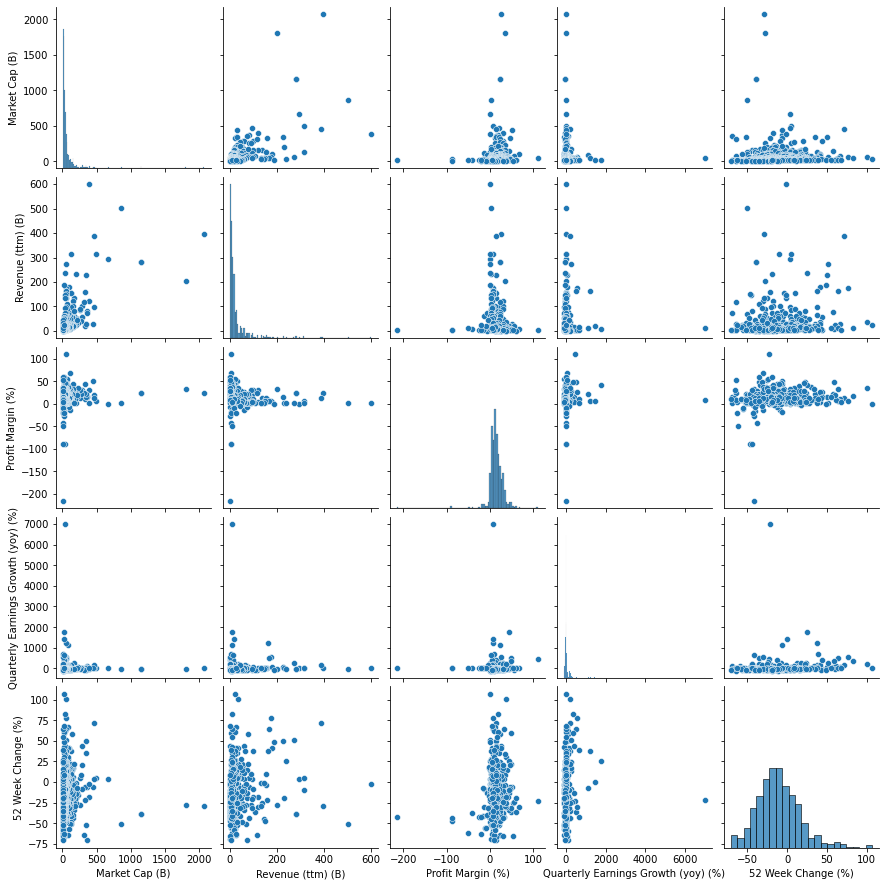

In [31]:
sns.pairplot(X);

<h2>MixMaxScaling</h2>
<p>Data to be inverse transformed after the analysis</p>

In [32]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()

X = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)
X.head()

,Market Cap (B),Revenue (ttm) (B),Profit Margin (%),Quarterly Earnings Growth (yoy) (%),52 Week Change (%)
Ticker,,,,,
Apple Inc. (AAPL),1.000000,0.656690,0.736196,0.014225,0.235955
Microsoft Corporation (MSFT),0.869313,0.337604,0.763804,0.012113,0.241573
"Amazon.com, Inc. (AMZN)",0.413740,0.836637,0.665644,0.012817,0.112360
Berkshire Hathaway Inc. (BRK-B),0.322109,0.492176,0.659509,0.014085,0.415730
Alphabet Inc. (GOOGL),0.554697,0.469469,0.733129,0.010423,0.179775


<h3>Elbow method to determine k number of clusters</h3>

Text(0.5, 1.0, 'Elbow curve')

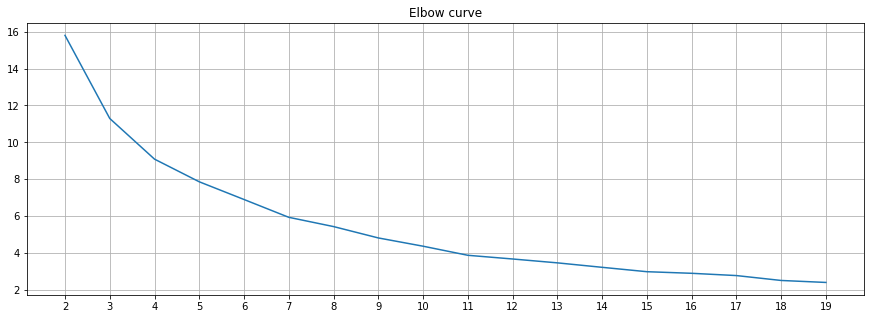

In [33]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

distorsions = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state = 42)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_) #Inertia is the sum of squared distances of samples to their closest cluster center.

fig = plt.figure(figsize=(15, 5))
plt.xticks(np.arange(2,21,1))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')

In [34]:
model = KMeans(random_state=42, init='k-means++', n_clusters=8)
sp_kmeans = model.fit(X)
sp_analysis_df = pd.DataFrame(scaler.inverse_transform(X), index=X.index, columns=X.columns)
sp_analysis_df['Cluster'] = sp_kmeans.labels_

display(sp_analysis_df.sort_values(by='Cluster'))

,Market Cap (B),Revenue (ttm) (B),Profit Margin (%),Quarterly Earnings Growth (yoy) (%),52 Week Change (%),Cluster
Ticker,,,,,,
"Hologic, Inc. (HOLX)",18.62,4.86,27.0,-64.0,4.0,0
"Air Products and Chemicals, Inc. (APD)",68.74,12.70,18.0,-4.0,5.0,0
"ONEOK, Inc. (OKE)",28.83,22.78,7.0,10.0,10.0,0
Molson Coors Beverage Company (TAP),11.22,10.69,5.0,-52.0,9.0,0
Boston Scientific Corporation (BSX),66.39,12.57,5.0,-55.0,7.0,0
...,...,...,...,...,...,...
"Tyler Technologies, Inc. (TYL)",13.36,1.83,10.0,20.0,-38.0,7
"Healthpeak Properties, Inc. (PEAK)",13.28,2.02,26.0,547.0,-30.0,7
"Akamai Technologies, Inc. (AKAM)",13.26,3.59,14.0,-40.0,-28.0,7


<h2>Determining Centroids and displaying the data</h2>

In [35]:
centroids_df = pd.DataFrame(scaler.inverse_transform(sp_kmeans.cluster_centers_), columns=features)
centroids_df['Cluster'] = centroids_df.index
centroids_df = centroids_df.transform(lambda x: round(x, 2))
centroids_df

,Market Cap (B),Revenue (ttm) (B),Profit Margin (%),Quarterly Earnings Growth (yoy) (%),52 Week Change (%),Cluster
0,59.45,24.00,14.45,30.43,13.52,0
1,57.67,22.60,14.80,22.10,-10.39,1
2,1405.76,332.76,21.80,-14.80,-37.20,2
3,306.69,320.38,4.56,57.89,19.44,3
4,49.01,27.57,-4.22,6.61,-52.47,4
5,57.73,57.56,14.48,196.96,56.60,5
6,37.60,12.10,8.00,7000.00,-22.00,6
7,38.51,14.88,20.30,18.76,-30.68,7


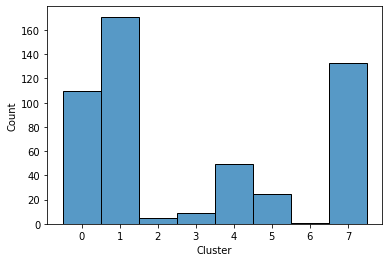

In [36]:
sns.histplot(sp_analysis_df['Cluster'], discrete=True);

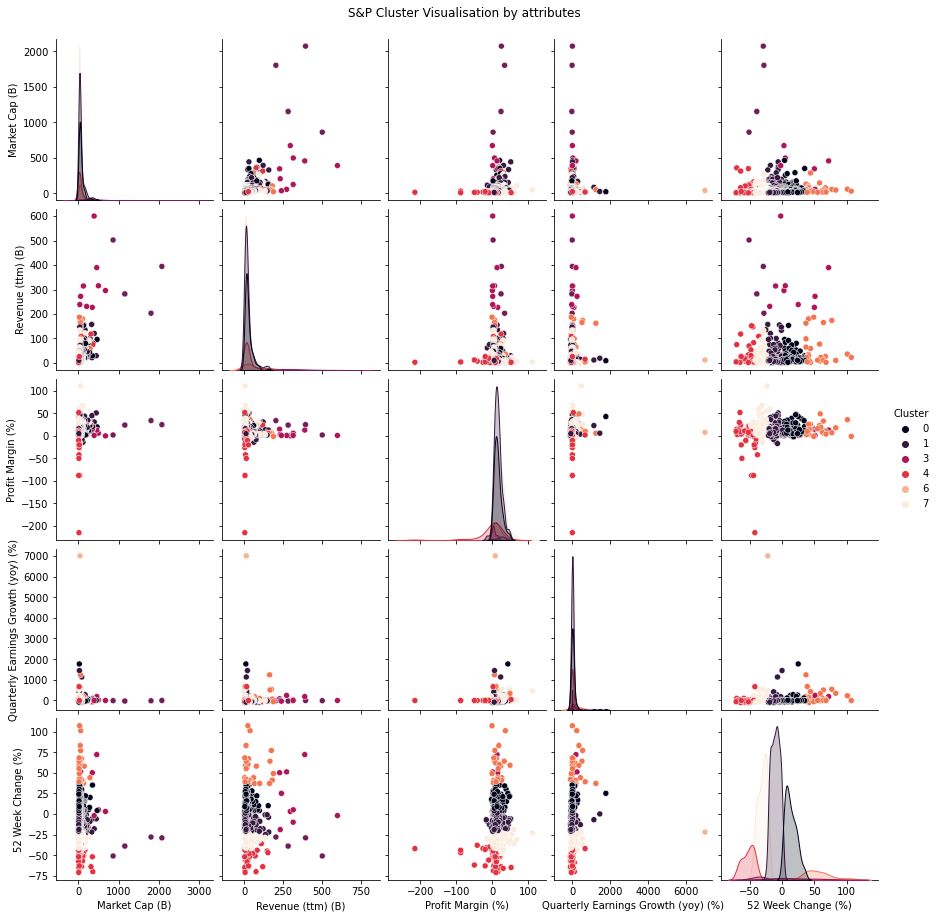

In [37]:
fig = sns.pairplot(sp_analysis_df, hue = 'Cluster', palette='rocket')
fig.fig.suptitle('S&P Cluster Visualisation by attributes', y=1.02)
fig.savefig('./data/s&p_clusters.jpg', dpi=300)

In [38]:
current_date = date.today().isoformat()
sp_analysis_df.to_csv(f'data/s&p_kmeans_{current_date}_source_{source_date}.csv')
print(f'Saved to file: s&p_kmeans_{current_date}_source_{source_date}.csv')

Saved to file: s&p_kmeans_2023-02-10_source_2022-12-31.csv


## Item 2 - Portfolio analysis
<h3>Using previously scrapped portfolio data to obtain clusters from trained model.</h3>

In [39]:
portfolio_df = pd.read_csv(f'data/portfolio_{source_date}.csv', index_col = 1)
X_test = portfolio_df.loc[:,features]
X_test = pd.DataFrame(scaler.fit_transform(X_test), index=X_test.index, columns=X_test.columns)

predicted_clusters = sp_kmeans.predict(X_test)
X_test = pd.DataFrame(scaler.inverse_transform(X_test), index=X_test.index, columns=X_test.columns)
X_test['Cluster'] = predicted_clusters
X_test.sort_values(by='Cluster')


,Market Cap (B),Revenue (ttm) (B),Profit Margin (%),Quarterly Earnings Growth (yoy) (%),52 Week Change (%),Cluster
Ticker,,,,,,
NVDA,405.92,28.57,21.0,-72.0,-50.0,0
CRWD,25.16,2.03,-9.0,0.0,-50.0,0
APPN,2.49,0.45,-32.0,0.0,-52.0,0
CRSP,3.61,0.01,0.0,0.0,-40.0,0
NNOX,0.44,0.01,0.0,0.0,-50.0,0
DDOG,23.17,1.53,-1.0,0.0,-60.0,1
HUBS,13.77,1.63,-7.0,0.0,-58.0,1
SNOW,45.14,1.86,-39.0,0.0,-60.0,1
MDB,13.88,1.19,-31.0,0.0,-65.0,1


### Comparing the portfolio stock types with that of S&P and its cluster centroid stats.

Comparison                           Centroid data                    \
             S&P % Portfolio % Difference % Market Cap (B) Revenue (ttm) (B)   
Cluster                                                                        
0             21.9        13.2         -8.7          59.45             24.00   
1             34.0        15.8        -18.2          57.67             22.60   
2              1.0         5.3          4.3        1405.76            332.76   
3              1.8         0.0         -1.8         306.69            320.38   
4              9.7        26.3         16.6          49.01             27.57   
5              5.0        15.8         10.8          57.73             57.56   
6              0.2        10.5         10.3          37.60             12.10   
7             26.4        13.2        -13.2          38.51             14.88   

                                                               \
        Profit Margin (%) Quarterly Earnings Growth (yoy) (%)   
Cluster                                                         
0                   14.45                               30.43   
1                   14.80                               22.10   
2                   21.80                              -14.80   
3                    4.56                               57.89   
4                   -4.22                                6.61   
5                   14.48                              196.96   
6                    8.00                             7000.00   
7                   20.30                               18.76   

                            
        52 Week Change (%)  
Cluster                     
0                    13.52  
1                   -10.39  
2                   -37.20  
3                    19.44  
4                   -52.47  
5                    56.60  
6                   -22.00  
7                   -30.68

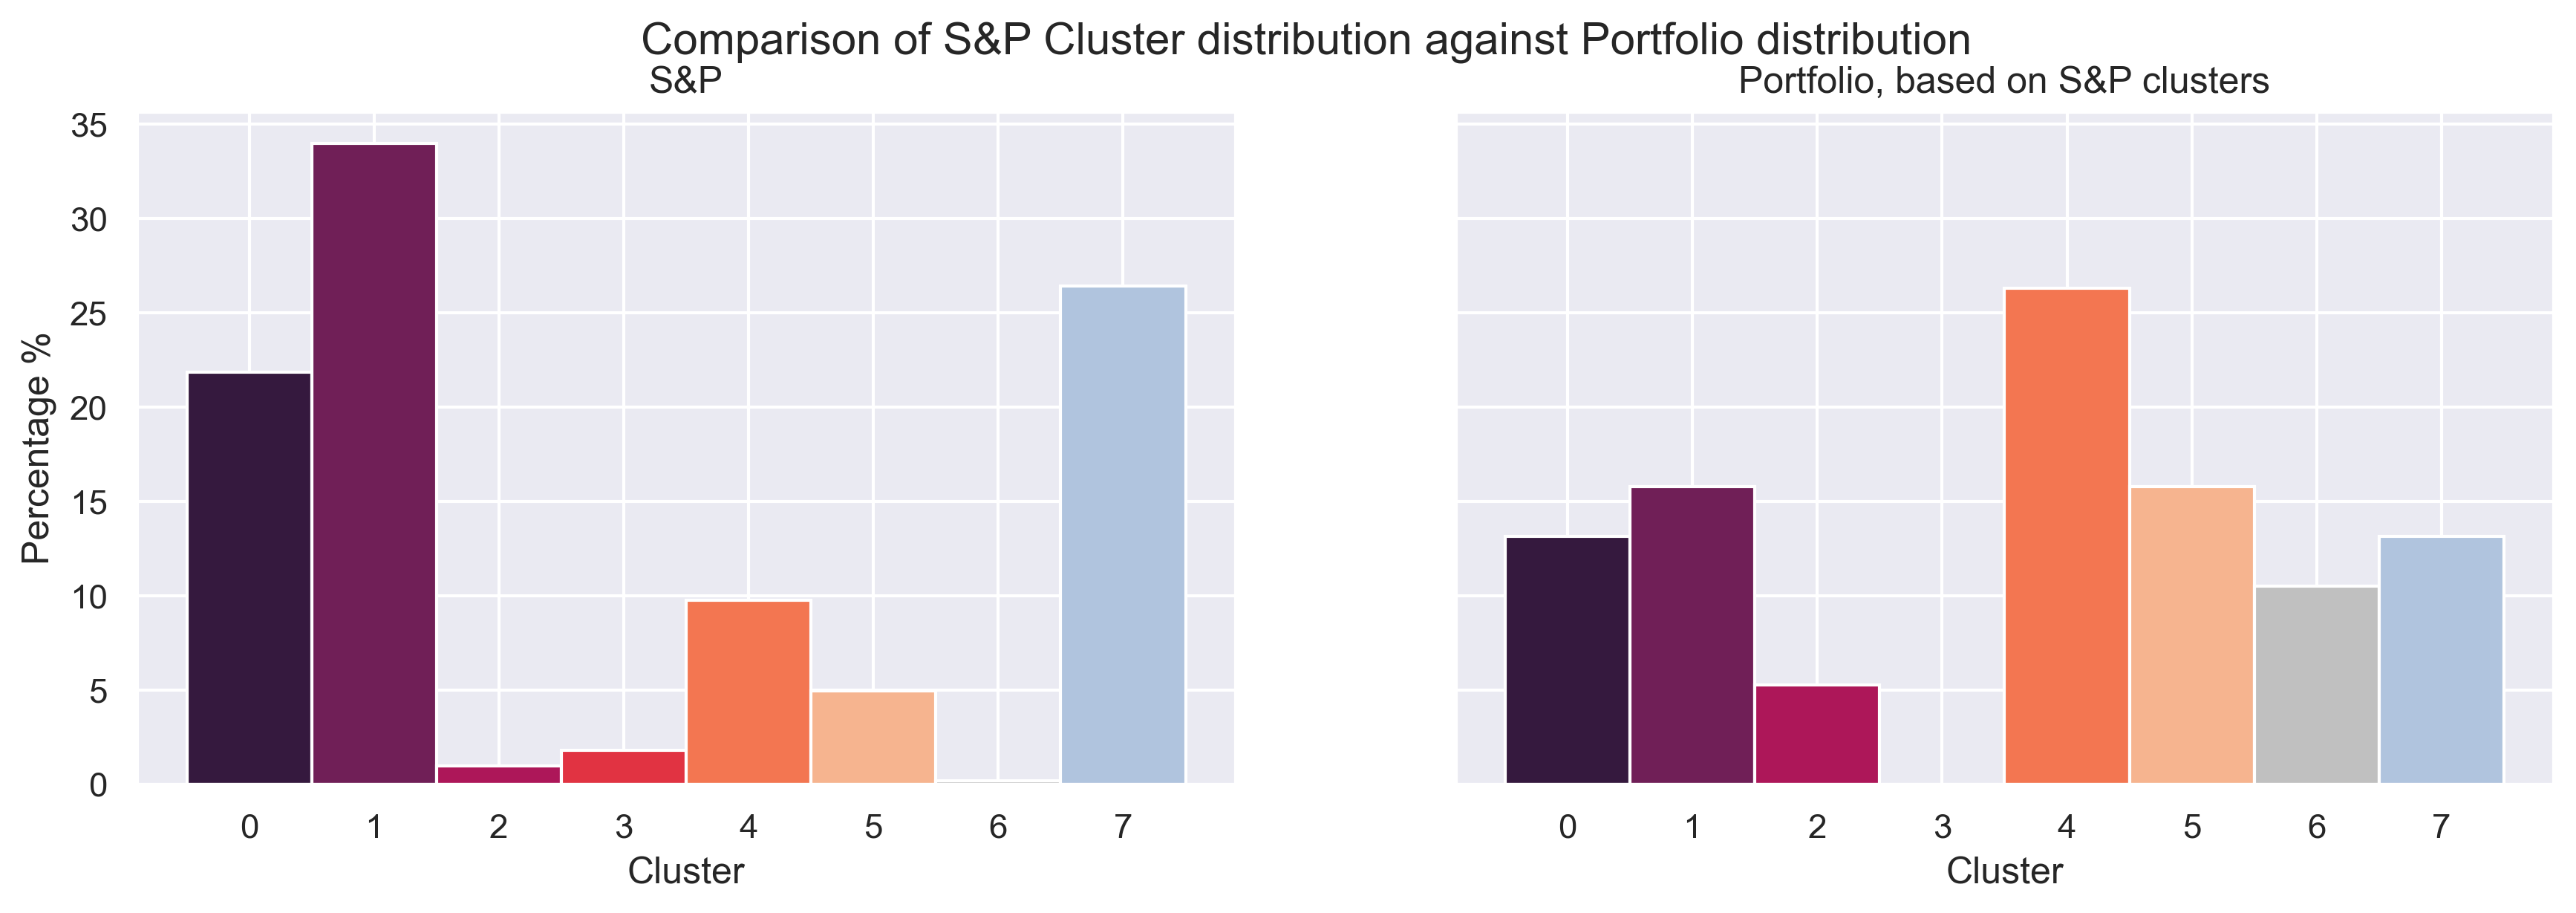

In [40]:
gb1 = sp_analysis_df.groupby('Cluster').count()
gb2 = X_test.groupby('Cluster').count()
gb = pd.concat ([gb1.iloc[:,0] ,gb2.iloc[:,0] ], axis = 1).transform(lambda x: round(x/x.sum()*100, 1))
gb.columns = ['S&P %','Portfolio %']
gb.fillna(0,inplace=True)
gb['Difference %'] = gb['Portfolio %'] - gb['S&P %']
gb = pd.concat ([gb, centroids_df.drop('Cluster', axis=1)], axis = 1, keys=['Comparison', 'Centroid data']) 
gb.index.name = 'Cluster'
display(gb)

sns.set(style = "darkgrid")
fig, (ax1,ax2) = plt.subplots(1,2, sharey=True, figsize=(14,4), dpi=300)

ax1 = sns.histplot(sp_analysis_df['Cluster'], discrete=True, stat='percent', ax=ax1)
ax1.set_title('S&P')
ax1.set_ylabel('Percentage %')

ax2 = sns.histplot(X_test['Cluster'], discrete=True, stat='percent', ax=ax2)
ax2.set_title('Portfolio, based on S&P clusters')

palette = sns.color_palette("rocket") +['silver', 'lightsteelblue']
for i in range(len(ax1.patches)):
    ax1.patches[i].set_facecolor(palette[i])
    ax2.patches[i].set_facecolor(palette[i])

fig.suptitle('Comparison of S&P Cluster distribution against Portfolio distribution')
plt.savefig('./data/cluster_differences.jpg', dpi=300)

### Getting recommendations

In [300]:
print('Required portfolio adjustments to match S&P percentage of companies:')
difference = gb.loc[:,'Comparison'].loc[:,'Difference %'].transform(lambda x: round(x/100*len(X_test),0)).to_dict()

for cluster, count in difference.items():
    if count<0:
        print(f'Sell {-int(count)} companies from cluster {cluster}.')

for cluster, count in difference.items():
    cond = sp_analysis_df['Cluster']==cluster
    possible_recs = (cond).sum()
    
    if count>0 and possible_recs >= count:
        display(sp_analysis_df[cond].sample(int(count)).style.set_caption(
            f'Buy {int(count)} companies from Cluster {cluster}').format(precision=2))
    elif possible_recs < count:
        display(sp_analysis_df[cond].sample(possible_recs).style.set_caption(
            f'Buy {int(count)} companies from Cluster {cluster}').format(precision=2))

Required portfolio adjustments to match S&P percentage of companies:
Sell 3 companies from cluster 0.
Sell 7 companies from cluster 1.
Sell 1 companies from cluster 3.
Sell 5 companies from cluster 7.


,Market Cap (B),Revenue (ttm) (B),Profit Margin (%),Quarterly Earnings Growth (yoy) (%),52 Week Change (%),Cluster
Ticker,,,,,,
Microsoft Corporation (MSFT),1800.00,203.07,34.00,-14.00,-28.00,2
Alphabet Inc. (GOOGL),1150.00,282.11,24.00,-26.00,-39.00,2


,Market Cap (B),Revenue (ttm) (B),Profit Margin (%),Quarterly Earnings Growth (yoy) (%),52 Week Change (%),Cluster
Ticker,,,,,,
"Bio-Rad Laboratories, Inc. (BIO)",12.28,2.80,-215.00,0.00,-42.00,4
DISH Network Corporation (DISH),7.16,17.08,11.00,-26.00,-58.00,4
Paramount Global (PARA),11.00,30.02,10.00,-57.00,-48.00,4
"Tesla, Inc. (TSLA)",355.91,74.86,15.00,104.00,-70.00,4
"Lumen Technologies, Inc. (LUMN)",5.48,18.52,11.00,6.00,-58.00,4
General Motors Company (GM),47.83,147.21,7.00,37.00,-45.00,4


,Market Cap (B),Revenue (ttm) (B),Profit Margin (%),Quarterly Earnings Growth (yoy) (%),52 Week Change (%),Cluster
Ticker,,,,,,
Occidental Petroleum Corporation (OXY),56.43,36.33,36.00,232.00,101.00,5
"First Solar, Inc. (FSLR)",16.01,2.52,4.00,0.00,68.00,5
Valero Energy Corporation (VLO),47.95,165.16,6.00,508.00,64.00,5
Halliburton Company (HAL),34.58,18.99,9.00,130.00,62.00,5


,Market Cap (B),Revenue (ttm) (B),Profit Margin (%),Quarterly Earnings Growth (yoy) (%),52 Week Change (%),Cluster
Ticker,,,,,,
Newmont Corporation (NEM),37.60,12.10,8.00,7000.00,-22.00,6


In [301]:
#manually choosing a category for random sampling
rec = 5
rec_count = 5
sp_analysis_df[sp_analysis_df['Cluster']==rec].sample(rec_count)

,Market Cap (B),Revenue (ttm) (B),Profit Margin (%),Quarterly Earnings Growth (yoy) (%),52 Week Change (%),Cluster
Ticker,,,,,,
APA Corporation (APA),14.53,10.87,33.0,0.0,64.0,5
Targa Resources Corp. (TRGP),16.29,21.82,3.0,6.0,38.0,5
Phillips 66 (PSX),49.21,162.31,6.0,1241.0,37.0,5
Archer-Daniels-Midland Company (ADM),51.43,98.71,4.0,96.0,37.0,5
Marathon Oil Corporation (MRO),16.88,7.70,49.0,344.0,59.0,5


## Conclusion and limitations:
<ol>
    <li>Note that this model has not accounted for index weighting and portfolio weighting. This needs to be done to have a full picture of how closely modeled the portfolio is to the S&P in terms of diversification.</li>
    <li>For example, Cluster 2, although low in percentage (2%), contains the companies Apple (AAPL), Microsoft (MFST), Amazon (AMZN) and Alphabet (GOOG) which together weigh more than 16% of the index.</li>
    </ol>